*Attention U-Net Based Adversarial Architectures for Chest X-ray Lung Segmentation*\
2020 Gaal, Maga, Lukacs\
[link](https://arxiv.org/pdf/2003.10304.pdf)

# Datasets

## Some publicly available datasets

- [JSRT](https://www.ajronline.org/doi/pdf/10.2214/ajr.174.1.1740071)
	- 247 chest X-rays, 154 have lung nodules. Has lung and heart seg.
	- [Get here](http://db.jsrt.or.jp/eng.php) (register at bottom of page)
- [Montgomery and Shenzhen](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/)
	- Montgomery contains 138 chest X-rays, 80 healthy, 58 tuberculosis. Has lung seg.
	- Shenzhen contains 662 chest X-rays, 326 healthy, 336 tuberculosis. Has lung seg.
	- [Get both here](https://openi.nlm.nih.gov/faq?it=xg#collection). Look for "tuberculosis collection"

That’s 1047 images with lung segmentation label. There are larger datasets that have no segmentation label:

- [NIH ChestX-ray8](https://arxiv.org/abs/1705.02315)
	- 108,948 CXRs of 32,717 patients with eight text-mined disease labels
	- [this might be a way to download](https://nihcc.app.box.com/v/ChestXray-NIHCC)
- [NLST](https://www.nejm.org/doi/10.1056/NEJMoa1102873)
	- There's [this link](https://cdas.cancer.gov/publications/320/), which eventually leads [here](https://cdas.cancer.gov/datasets/nlst/), but I don't see any actual CXR images being made available.
 

### JSRT

See [this guide](JSRT_UsersGuide.pdf) to the data for details.

- `JPCLN***.IMG` for chest lung nodule images, and `JPCNN***.IMG` for non-nodule images. These are important classes to keep in mind for the purpose of proportional train/val/test split.
-  coordinates of the upper left of the image are `(0,0)`
- Image type: 16-bit Unsigned
- Width: 2048 pixels
- Height: 2048 pixels
- Offset to First Image: 0 bytes
- Gap Between Images: 0 bytes

You can load the images using [ImageJ](https://imagej.nih.gov/ij/).
Just import as "RAW" and put in the settings specified by the JSRT guide.

Hmm, stuck on this for now... also where are the segmentations? When I load RAW data into Image J I only see an xray image, and I see no reference to segmentation in the JSRT guide. The JSRT download page doesn't say anything about segmentation labels either.

### Shenzhen

[The readme](NLM-ChinaCXRSet-ReadMe.pdf).

- 336 cases with manifestation of tuberculosis, and 
- 326 normal cases.

- Format: PNG
- Image size varies for each X-ray. It is approximately 3K x 3K.

- Image file names are coded as `CHNCXR_#####_0/1.png`, where ‘0’ represents the normal and ‘1’
represents the abnormal lung. 

Hmm I also cannot find any lung segmentation for this. And [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4256233/) that introduces the dataset seems to suggest that it's just the Montgomery set that has the segmentation.

### Montgomery

[The readme](NLM-MontgomeryCXRSet-ReadMe.pdf).

- 58 cases	with	manifestation	of	tuberculosis,	and	 80 normal	cases.
- Image	 file	 names	are	 coded	as	`MCUCXR_#####_0/1.png`, where	‘0’	 represents	 the	 normal	and	‘1’ represents	the	abnormal	lung. These are important classes to keep in mind for the purpose of proportional train/val/test split.

---

- Format:	PNG
- Matrix	size	is	4020	x	4892,	or	4892	x	4020.
- The	pixel	spacing	in	vertical	and	horizontal	directions	is	0.0875	mm.	
- Number	of	gray	levels	is	12 bits.

---

Segmentation:
> We	manually	generated	the	“gold	standard” segmentations	for	the	chest	X-ray	under	the	supervision	of a	radiologist.	We	used	the	following	conventions	for outlining	the	lung	boundaries:	Both	posterior	and	anterior	ribs	are	readily	visible	in	the	CXRs;	the	part	of	the	lung	behind	the	heart	is	excluded.	We	follow	anatomical	 landmarks	 such	 as	 the	 boundary	 of	 the	 heart,	 aortic	 arc/line,	 and	 pericardium	 line;	 and	sharp	costophrenic	angle	that	follow	the	diaphragm	boundary. We	draw	an	inferred	boundary	when	the	pathology	is	severe	and	affects	the	morphological	appearance	of	the	lungs. The	lung	boundaries	(left	and	right)	are	in	binary	image	format	and	have	the	same	file	name	as	chest	Xrays	( e.g.	`…/left/MCUCXR_#####_0/1.png` or	`…/right/MCUCXR_#####_0/1.png`). 

Looks like this is the one we can actually use here.

In [1]:
import os, glob

dataset_base_path = '/home/ebrahim/data/chest_xrays/MontgomerySet'
dataset_imgs_path = os.path.join(dataset_base_path, 'CXR_png/')
dataset_seg_path_left = os.path.join(dataset_base_path, 'ManualMask/leftMask')
dataset_seg_path_right = os.path.join(dataset_base_path, 'ManualMask/rightMask')

imgs = glob.glob(os.path.join(dataset_imgs_path, '*.png'))
segs_left = glob.glob(os.path.join(dataset_seg_path_left, '*.png'))
segs_right = glob.glob(os.path.join(dataset_seg_path_right, '*.png'))

file_path_to_ID = lambda p : os.path.basename(p)[7:11]
file_path_to_abnormality = lambda p : bool(int(os.path.basename(p)[12]))

img_ids = list(map(file_path_to_ID,imgs));
seg_ids_left = list(map(file_path_to_ID,segs_left));
seg_ids_right = list(map(file_path_to_ID,segs_right));

data = []
for img in imgs:
    img_id = file_path_to_ID(img)
    seg_left = segs_left[seg_ids_left.index(img_id)]
    seg_right = segs_right[seg_ids_right.index(img_id)]
    tuberculosis = file_path_to_abnormality(img)
    data.append({
        'img' : img,
        'seg_left' : seg_left,
        'seg_right' : seg_right,
        'tuberculosis' : tuberculosis

    })

In [2]:
import monai
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
data_train, data_valid = monai.data.utils.partition_dataset_classes(
    data,
    classes = list(map(lambda d : d['tuberculosis'], data)),
    ratios = (8,2)
)

In [4]:
# Custom transforms
from typing import Mapping, Hashable, List

class MasksToOneHotD(monai.transforms.MapTransform):
    def __init__(self, keys: monai.config.KeysCollection,
                 keyList: List[Hashable], newKeyName: str) -> None:
        super().__init__(keys)
        self.keyList = keyList
        self.newKeyName = newKeyName
        assert(len(keyList)>0)

    def __call__(self, data: Mapping[Hashable, np.ndarray]) -> Mapping[Hashable, np.ndarray]:
        
        # (if this were to be contributed, I'd have to pay attention to whether keys are in data)
        # (also I'd want to raise more clear exceptions than these asserts)
        
        assert(all(key in self.keys for key in self.keyList))
        assert(all(key in data.keys() for key in self.keyList))
        assert(self.newKeyName not in data.keys())
        
        background_mask = (sum(data[key] for key in self.keyList)==0).astype('int8')
        
        # Assumes these were numpy arrays.
        # If they were torch tensors we'd have to do "torch.stack" and use argument "dim" instead of "axis"
        data[self.newKeyName] = np.stack(
            [background_mask] + [data[key] for key in self.keyList],
            axis=0
        )
        
        return data


In [5]:
image_size = 1024

transform_valid = monai.transforms.Compose([
    monai.transforms.LoadImageD(keys = ['img']),
    monai.transforms.LoadImageD(keys = ['seg_left', 'seg_right'], dtype="int8"),
    monai.transforms.TransposeD(keys = ['img', 'seg_left', 'seg_right'], indices = (1,0)),
    monai.transforms.AddChannelD(keys = ['img']),
    MasksToOneHotD(
        keys = ['seg_left', 'seg_right'],
        keyList = ['seg_left', 'seg_right'],
        newKeyName = 'seg'
    ),
    monai.transforms.DeleteItemsD(keys = ['seg_left', 'seg_right']),
    monai.transforms.ResizeD(keys = ['img', 'seg'], spatial_size=(image_size,image_size)),
    monai.transforms.ToTensorD(keys = ['img', 'seg']),
])

transform_train = monai.transforms.Compose([
    transform_valid,
    monai.transforms.RandRotateD(keys = ['img', 'seg'],
                                 range_x = np.pi/8,
                                 padding_mode="zeros",
                                 prob=1.,
                                 mode = ['bilinear', 'nearest'])
])

In [6]:
# TODO: switch back to CacheDataset once ready to start training

dataset_train = monai.data.CacheDataset(data_train, transform_train)
dataset_valid = monai.data.CacheDataset(data_valid, transform_valid)
# dataset_train = monai.data.Dataset(data_train, transform_train)
# dataset_valid = monai.data.Dataset(data_valid, transform_valid)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 11.50it/s]


In [7]:
dataset_train[0].keys()

dict_keys(['img', 'tuberculosis', 'img_meta_dict', 'seg_left_meta_dict', 'seg_right_meta_dict', 'img_transforms', 'seg_left_transforms', 'seg_right_transforms', 'seg', 'seg_transforms'])

# Previewing

In [8]:
def preview(data_item):
    fig = plt.figure(figsize=(7,7))
    im = data_item['img'].expand((3,)+data_item['img'].shape[1:])
    im = im/im.max()
    seg = data_item['seg'].float()
    im[1,:,:] *= 1-0.3*seg[1,:,:]
    im[2,:,:] *= 1-0.3*seg[2,:,:]
    im = np.transpose(im,axes=(1,2,0))
    plt.imshow(im, cmap='bone')
    plt.plot();

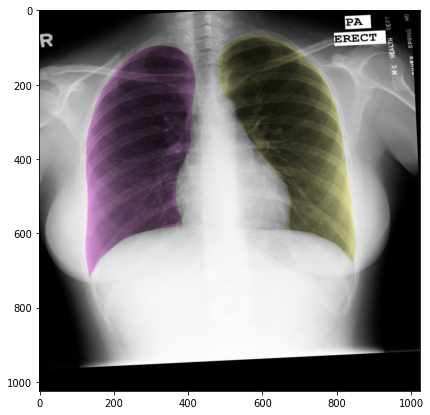

In [9]:
import random
preview(random.choice(dataset_train))

Note that some images have different original dimensions. Some are (4020, 4892) and some are (4892, 4020). 

# seg net

Structure of U-Net is inspired by this paper: https://arxiv.org/abs/1703.08770

But it's not exactly the same.

And it looks like there's one giant deconvolution step at the end, instead of having a symmetric looking unet.

In [10]:
spatial_dims = 2;
image_channels = 1;
seg_channels = 3; # left lung, right lung, background
seg_net_channel_seq = (8,8,16,32,64,64)
stride_seq = (2,2,2,2,2) # I don't know why, but MONAI unet insists on this being one shorter than I expect,
# and then it forces a stride of 1 at that last step.
dropout = 0.2
num_res_units = 1

seg_net = monai.networks.nets.UNet(
    spatial_dims = spatial_dims,
    in_channels = image_channels,
    out_channels = seg_channels, 
    channels = seg_net_channel_seq,
    strides = (2,2,2,2,2),
    dropout = dropout,
    num_res_units = num_res_units
)

num_params = sum(p.numel() for p in seg_net.parameters())
print(f"seg_net has {num_params} parameters")

seg_net has 149734 parameters


# critic network

Same shape as UNET but with the upsampling half lopped off and replaced by a fully connected layer.

The output is a single logit-- needs sigmoid to make it a probability.

It will be the probability that a given segmentation was from the training set.
So the critic network is encouraged to output 1 on ground truth seg labels,
and it's encouraged to output 0 on segmentations that were made by `seg_net`.

In [11]:
critic_channels_and_strides = list(zip((seg_channels,) + seg_net_channel_seq,seg_net_channel_seq, stride_seq+(1,)))

downsample_factor = np.array(critic_channels_and_strides)[:,2].prod()
last_conv_layer_channels = np.array(critic_channels_and_strides)[-1,1]
last_conv_layer_image_size = image_size // downsample_factor



print("critic_net in_channels, out_channels, and strides for the convolutional part:")
print(critic_channels_and_strides)

critic_net = torch.nn.Sequential(
    *[
        monai.networks.blocks.convolutions.ResidualUnit(
            spatial_dims,
            in_channels,
            out_channels,
            strides = stride,
            subunits = num_res_units,
            dropout = dropout,
        )
        for in_channels, out_channels, stride in critic_channels_and_strides
    ],
    monai.networks.layers.Flatten(),
    torch.nn.Linear(last_conv_layer_image_size**2 * last_conv_layer_channels, 1) # output is logit; needs sigmoid
)


num_params = sum(p.numel() for p in critic_net.parameters())
print(f"critic_net has {num_params} parameters")

critic_net in_channels, out_channels, and strides for the convolutional part:
[(3, 8, 2), (8, 8, 2), (8, 16, 2), (16, 32, 2), (32, 64, 2), (64, 64, 1)]
critic_net has 152695 parameters


# Loss

In [12]:
dice_loss = monai.losses.DiceLoss(
    to_onehot_y = False, # the segs we pass in are already in one-hot form due to MasksToOneHotD defined above
    softmax = True, # Note that our segmentation network is missing the softmax at the end
)

In [13]:
# Test drive
data_item = dataset_train[42]
seg_pred = seg_net(data_item['img'].unsqueeze(0)) # shape is (1,3,1024,1024), which is (B,N,H,W)

dice_loss(
    seg_net(data_item['img'].unsqueeze(0)), # input, one-hot
    data_item['seg'].unsqueeze(0), # target, one-hot
)

tensor(0.7583, grad_fn=<MeanBackward0>)

In [14]:
bce_loss_logits = torch.nn.BCEWithLogitsLoss()

In [15]:
# Test drive
data_item = dataset_train[42]
critic_pred = critic_net(data_item['seg'].unsqueeze(0))

bce_loss_logits(critic_pred[0],torch.tensor([0.]))

tensor(0.5239, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

# Previewing seg net outputs

In [16]:
def preview_seg_net(data_item, figsize=(15,10), print_loss = True):
    
    seg_net.eval()
    
    with torch.no_grad():
        im_device = data_item['img'].to(next(seg_net.parameters()).device.type)
        seg_pred = seg_net(im_device.unsqueeze(0))[0].cpu()
        _, max_indices = seg_pred.max(dim=0)
        seg_pred_mask1 = (max_indices==1).type(torch.int8)
        seg_pred_mask2 = (max_indices==2).type(torch.int8)

        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)

        im = data_item['img'].expand((3,)+data_item['img'].shape[1:])
        im = im/im.max()

        seg_true = data_item['seg'].float()
        im_true = im.clone()
        im_true[1,:,:] *= 1-0.3*seg_true[1,:,:]
        im_true[2,:,:] *= 1-0.3*seg_true[2,:,:]
        im_true = np.transpose(im_true,axes=(1,2,0))
        ax1.imshow(im_true, cmap='bone')
        ax1.set_title("true seg overlay")
        ax1.axis('off')

        ax2.imshow(max_indices)
        ax2.set_title("predicted seg")
        ax2.axis('off')

        fig = plt.figure(figsize=(5,5))
        im_pred = im.clone()
        im_pred[1,:,:] *= 1-0.6*seg_pred_mask1
        im_pred[2,:,:] *= 1-0.6*seg_pred_mask2
        im_pred = np.transpose(im_pred,axes=(1,2,0))
        ax3.imshow(im_pred, cmap='bone')
        ax3.set_title("predicted seg overlay")
        ax3.axis('off')

        plt.show();

        if print_loss:
            loss = dice_loss(
                seg_pred.unsqueeze(0),
                data_item['seg'].unsqueeze(0),
            )
            print(f"Dice loss: {loss.item()}")

In [17]:
# Try seg_net on a random image.
# preview_seg_net(random.choice(dataset_train));

# Previewing critic net outputs

In [18]:
def preview_critic_net(data_item):
    critic_net.eval()
    seg_net.eval()
    
    with torch.no_grad():
    
        seg_net_device = next(seg_net.parameters()).device.type;
        critic_net_device = next(critic_net.parameters()).device.type;
        seg_pred = seg_net(data_item['img'].unsqueeze(0).to(seg_net_device)).cpu()
        seg_true = data_item['seg'].float().unsqueeze(0)

        # logit
        critic_generated_seg = critic_net(seg_pred.to(critic_net_device)).cpu()
        critic_real_seg = critic_net(seg_true.to(critic_net_device)).cpu()
        
        # probability
        critic_generated_seg_p = critic_generated_seg.sigmoid().item()
        critic_real_seg_p = critic_real_seg.sigmoid().item()

        print(f"Critic network confidence in the generated segmentation: {critic_generated_seg_p}")
        print(f"Associated BCE loss: {bce_loss_logits(critic_generated_seg,torch.tensor([[0.]]))}")
        print(f"Critic network confidence in the ground truth segmentation: {critic_real_seg_p}")
        print(f"Associated BCE loss: {bce_loss_logits(critic_real_seg,torch.tensor([[1.]]))}")
    


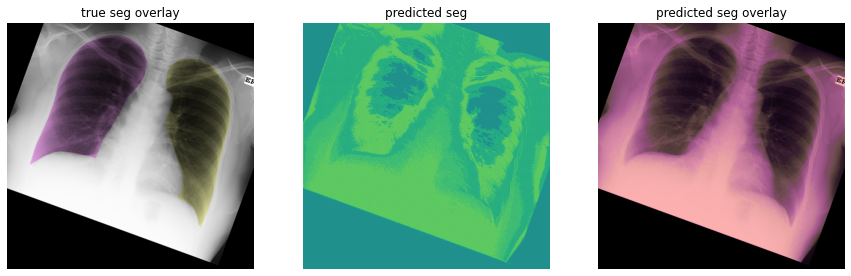

<Figure size 360x360 with 0 Axes>

Dice loss: 0.7786709666252136
Critic network confidence in the generated segmentation: 0.270037442445755
Associated BCE loss: 0.3147621154785156
Critic network confidence in the ground truth segmentation: 0.3526017367839813
Associated BCE loss: 1.0424160957336426


In [19]:
# Try seg_net on a random image.
data_tiem  = random.choice(dataset_train)
preview_seg_net(data_tiem);
preview_critic_net(data_tiem);

# Training

## Pretraining seg net alone

In [20]:
seg_net.to('cuda')

dataloader_train = monai.data.DataLoader(
    dataset_train,
    batch_size=16,
    num_workers=8,
    shuffle=True
)

dataloader_valid = monai.data.DataLoader(
    dataset_valid,
    batch_size=16,
    num_workers=8,
    shuffle=False
)

learning_rate = 1e-3
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

max_epochs = 30
training_losses = [] 
validation_losses = []

for epoch_number in range(max_epochs):
    
    seg_net.train()
    losses = []
    for batch in dataloader_train:
        imgs = batch['img'].to('cuda')
        true_segs = batch['seg'].to('cuda')

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    
    seg_net.eval()
    losses = []
    with torch.no_grad():
        for batch in dataloader_valid:
            imgs = batch['img'].to('cuda')
            true_segs = batch['seg'].to('cuda')
            predicted_segs = seg_net(imgs)
            loss = dice_loss(predicted_segs, true_segs)
            losses.append(loss.item())
        validation_loss = np.mean(losses)
        
    print(f"Epoch {epoch_number+1}/{max_epochs}\n\ttraining loss: {training_loss}\n\tvalidation loss: {validation_loss}")
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)

Epoch 1/30
	training loss: 0.7195105467523847
	validation loss: 0.7060838341712952
Epoch 2/30
	training loss: 0.7090711508478437
	validation loss: 0.7001729011535645
Epoch 3/30
	training loss: 0.7036522115979876
	validation loss: 0.6944276988506317
Epoch 4/30
	training loss: 0.6971322298049927
	validation loss: 0.6889943480491638
Epoch 5/30
	training loss: 0.6865752424512591
	validation loss: 0.6711361110210419
Epoch 6/30
	training loss: 0.6633331945964268
	validation loss: 0.6512990891933441
Epoch 7/30
	training loss: 0.650523134640285
	validation loss: 0.6444875299930573
Epoch 8/30
	training loss: 0.6426917314529419
	validation loss: 0.6350553631782532
Epoch 9/30
	training loss: 0.6332775269235883
	validation loss: 0.6267702877521515
Epoch 10/30
	training loss: 0.6254666447639465
	validation loss: 0.6201833486557007
Epoch 11/30
	training loss: 0.6169852018356323
	validation loss: 0.6145745813846588
Epoch 12/30
	training loss: 0.6097991040774754
	validation loss: 0.6093026101589203
Ep

In [21]:
del imgs, true_segs, predicted_segs, loss
torch.cuda.empty_cache()

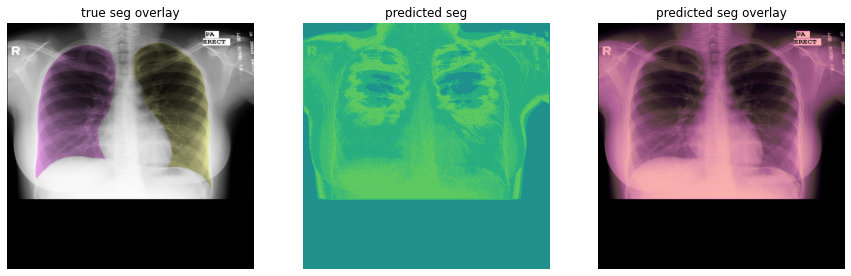

<Figure size 360x360 with 0 Axes>

Dice loss: 0.7639143466949463


In [20]:
preview_seg_net(random.choice(dataset_valid))

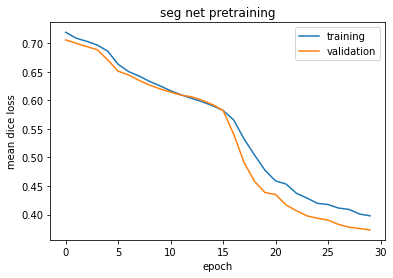

In [23]:
plt.plot(training_losses, label="training")
plt.plot(validation_losses, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mean dice loss')
plt.title('seg net pretraining')
plt.savefig('seg_net_pretraining_losses.png')
plt.show()

## Alternate training with critic network

In [21]:
def swap_training(network_to_train, network_to_not_train):
    """
        Switch out of training one network and into training another
    """

    for param in network_to_not_train.parameters():
        param.requires_grad = False
    
    for param in network_to_train.parameters():
        param.requires_grad = True
        
    network_to_not_train.eval()
    network_to_train.train()

Epoch 1/100
	seg training loss: 0.3008003234863281
	seg validation loss: 0.24744349718093872


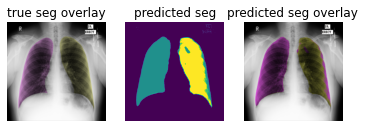

<Figure size 360x360 with 0 Axes>

Dice loss: 0.1956665962934494
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 2/100
	seg training loss: 0.29269351278032574
	seg validation loss: 0.24709631502628326


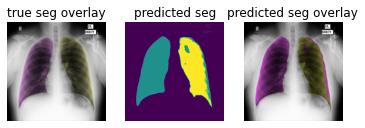

<Figure size 360x360 with 0 Axes>

Dice loss: 0.19646602869033813
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 3/100
	seg training loss: 0.2884162451539721
	seg validation loss: 0.23860955983400345


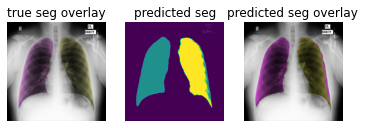

<Figure size 360x360 with 0 Axes>

Dice loss: 0.18753373622894287
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 4/100
	seg training loss: 0.28227148737226215
	seg validation loss: 0.23501275479793549


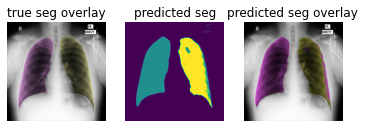

<Figure size 360x360 with 0 Axes>

Dice loss: 0.18592680990695953
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 5/100
	seg training loss: 0.2810502903802054
	seg validation loss: 0.2330196350812912


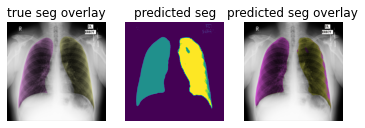

<Figure size 360x360 with 0 Axes>

Dice loss: 0.18175184726715088
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 6/100
	seg training loss: 0.27521346296582905
	seg validation loss: 0.22863984107971191


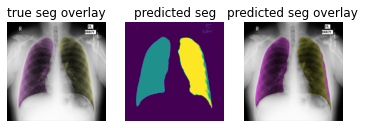

<Figure size 360x360 with 0 Axes>

Dice loss: 0.17666201293468475
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 7/100
	seg training loss: 0.2772177628108433
	seg validation loss: 0.2250853329896927


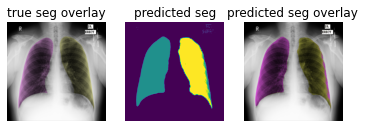

<Figure size 360x360 with 0 Axes>

Dice loss: 0.17167244851589203
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 8/100
	seg training loss: 0.27248397043773104
	seg validation loss: 0.22125038504600525


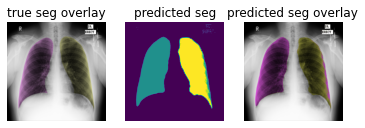

<Figure size 360x360 with 0 Axes>

Dice loss: 0.16750817000865936
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 9/100
	seg training loss: 0.26812795656067984
	seg validation loss: 0.21778889745473862


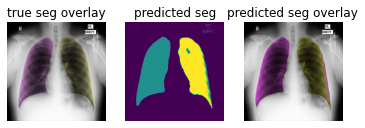

<Figure size 360x360 with 0 Axes>

Dice loss: 0.16386467218399048
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 10/100
	seg training loss: 0.26302311037267956
	seg validation loss: 0.21159210801124573


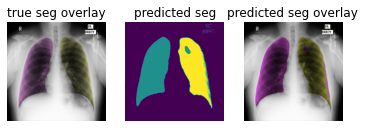

<Figure size 360x360 with 0 Axes>

Dice loss: 0.1607937216758728
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 11/100
	seg training loss: 0.25493012155805317
	seg validation loss: 0.20375563949346542


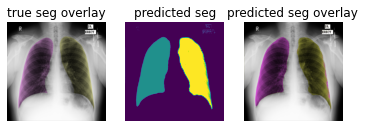

<Figure size 360x360 with 0 Axes>

Dice loss: 0.15000669658184052
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 12/100
	seg training loss: 0.25199177648339954
	seg validation loss: 0.1948176622390747


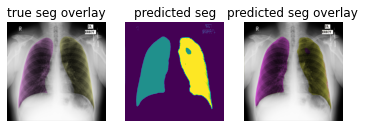

<Figure size 360x360 with 0 Axes>

Dice loss: 0.14453427493572235
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 13/100
	seg training loss: 0.2452456738267626
	seg validation loss: 0.18257463723421097


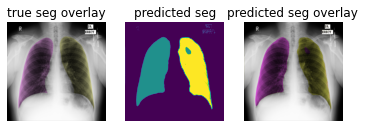

<Figure size 360x360 with 0 Axes>

Dice loss: 0.136215940117836
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 14/100
	seg training loss: 0.2363482607262475
	seg validation loss: 0.16880781203508377


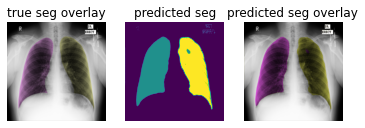

<Figure size 360x360 with 0 Axes>

Dice loss: 0.12260238081216812
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 15/100
	seg training loss: 0.22632006023611342
	seg validation loss: 0.15243565291166306


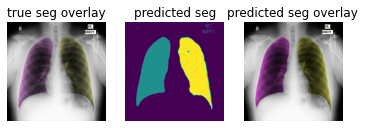

<Figure size 360x360 with 0 Axes>

Dice loss: 0.11092106252908707
	critic training loss: 0.0
	critic validation loss: 8.31950569152832
Epoch 16/100
	seg training loss: 0.21064867079257965
	seg validation loss: 0.1380303017795086


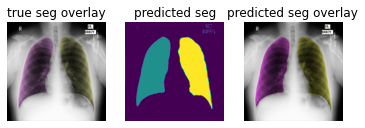

<Figure size 360x360 with 0 Axes>

Dice loss: 0.09901360422372818
	critic training loss: 0.0
	critic validation loss: 30.050960540771484
Epoch 17/100
	seg training loss: 0.202796214393207
	seg validation loss: 0.12747735530138016


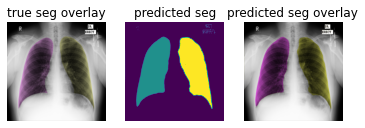

<Figure size 360x360 with 0 Axes>

Dice loss: 0.09367895126342773
	critic training loss: 0.0
	critic validation loss: 69.97978973388672
Epoch 18/100
	seg training loss: 0.19445202606064932
	seg validation loss: 0.11817653849720955


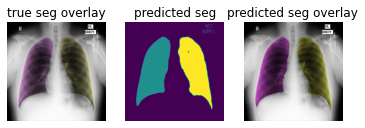

<Figure size 360x360 with 0 Axes>

Dice loss: 0.0864294171333313
	critic training loss: 0.0
	critic validation loss: 62.17517852783203
Epoch 19/100
	seg training loss: 0.18504239405904496
	seg validation loss: 0.11330786719918251


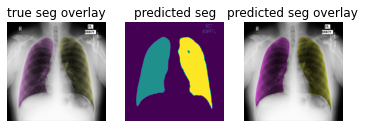

<Figure size 360x360 with 0 Axes>

Dice loss: 0.08155989646911621
	critic training loss: 1.9808523995535714
	critic validation loss: 0.0
Epoch 20/100
	seg training loss: 0.2039450066430228
	seg validation loss: 0.13024383038282394


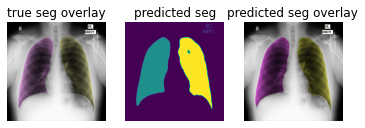

<Figure size 360x360 with 0 Axes>

Dice loss: 0.07979822158813477
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 21/100
	seg training loss: 0.20963753121239798
	seg validation loss: 0.13458553701639175


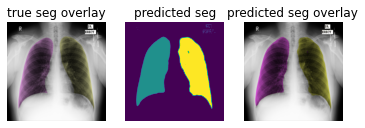

<Figure size 360x360 with 0 Axes>

Dice loss: 0.07652529329061508
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 22/100
	seg training loss: 0.2057593081678663
	seg validation loss: 0.13407090306282043


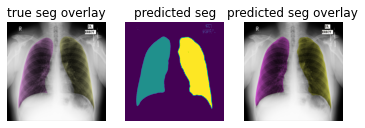

<Figure size 360x360 with 0 Axes>

Dice loss: 0.07413103431463242
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 23/100
	seg training loss: 0.20418732294014522
	seg validation loss: 0.13209111243486404


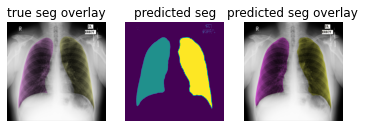

<Figure size 360x360 with 0 Axes>

Dice loss: 0.07348626852035522
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 24/100
	seg training loss: 0.19856983636106765
	seg validation loss: 0.1284194327890873


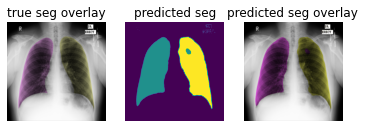

<Figure size 360x360 with 0 Axes>

Dice loss: 0.0731804370880127
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 25/100
	seg training loss: 0.19395156630447932
	seg validation loss: 0.12350311875343323


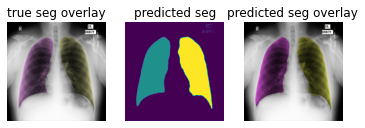

<Figure size 360x360 with 0 Axes>

Dice loss: 0.06582281738519669
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 26/100
	seg training loss: 0.18765025479452951
	seg validation loss: 0.12191440910100937


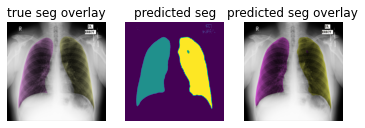

<Figure size 360x360 with 0 Axes>

Dice loss: 0.0647488608956337
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 27/100
	seg training loss: 0.1827779816729682
	seg validation loss: 0.11811415106058121


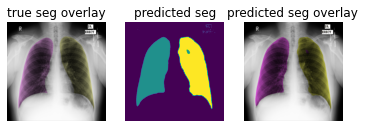

<Figure size 360x360 with 0 Axes>

Dice loss: 0.06368446350097656
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 28/100
	seg training loss: 0.18003653841359274
	seg validation loss: 0.11621502414345741


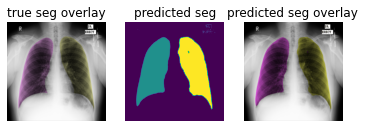

<Figure size 360x360 with 0 Axes>

Dice loss: 0.06158852577209473
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 29/100
	seg training loss: 0.17661836530481065
	seg validation loss: 0.11365598440170288


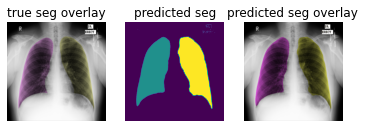

<Figure size 360x360 with 0 Axes>

Dice loss: 0.057831842452287674
	critic training loss: 31.038792201450892
	critic validation loss: 0.0
Epoch 30/100
	seg training loss: 0.15466519338744028
	seg validation loss: 0.09383414685726166


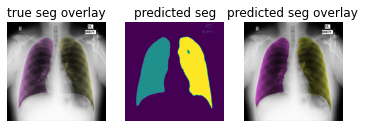

<Figure size 360x360 with 0 Axes>

Dice loss: 0.05652095749974251
	critic training loss: 0.0
	critic validation loss: 105.33711242675781
Epoch 31/100
	seg training loss: 0.13800285969461715
	seg validation loss: 0.07919295877218246


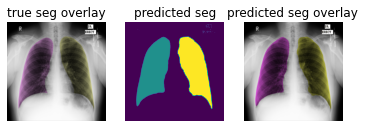

<Figure size 360x360 with 0 Axes>

Dice loss: 0.051973164081573486
	critic training loss: 4.2677748543875555
	critic validation loss: 0.0
Epoch 32/100
	seg training loss: 0.1621112780911582
	seg validation loss: 0.10453822463750839


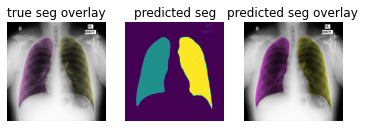

<Figure size 360x360 with 0 Axes>

Dice loss: 0.05245983600616455
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 33/100
	seg training loss: 0.1855574675968715
	seg validation loss: 0.12361832335591316


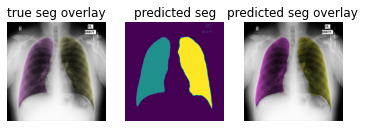

<Figure size 360x360 with 0 Axes>

Dice loss: 0.053371328860521317
	critic training loss: 0.0
	critic validation loss: 97.05255126953125
Epoch 34/100
	seg training loss: 0.1960506056036268
	seg validation loss: 0.13358020037412643


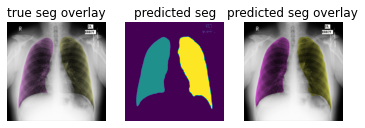

<Figure size 360x360 with 0 Axes>

Dice loss: 0.05330566689372063
	critic training loss: 0.0
	critic validation loss: 175.38044452667236
Epoch 35/100
	seg training loss: 0.19382749497890472
	seg validation loss: 0.1359124407172203


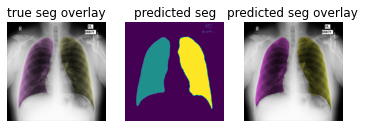

<Figure size 360x360 with 0 Axes>

Dice loss: 0.05452348664402962
	critic training loss: 0.0
	critic validation loss: 242.9791374206543
Epoch 36/100
	seg training loss: 0.19339155937944139
	seg validation loss: 0.137300793081522


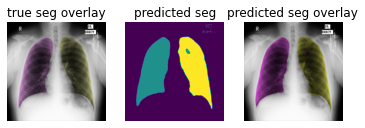

<Figure size 360x360 with 0 Axes>

Dice loss: 0.056194525212049484
	critic training loss: 6.352558680943081
	critic validation loss: 0.0
Epoch 37/100
	seg training loss: 0.1848164860691343
	seg validation loss: 0.12897110730409622


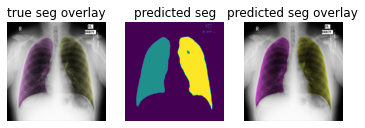

<Figure size 360x360 with 0 Axes>

Dice loss: 0.05404961109161377
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 38/100
	seg training loss: 0.1777919509581157
	seg validation loss: 0.11883154511451721


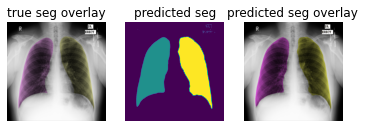

<Figure size 360x360 with 0 Axes>

Dice loss: 0.05038686469197273
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 39/100
	seg training loss: 0.17072364049298422
	seg validation loss: 0.11498506367206573


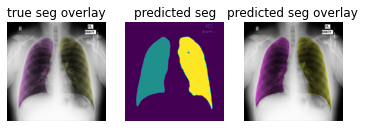

<Figure size 360x360 with 0 Axes>

Dice loss: 0.051770467311143875
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 40/100
	seg training loss: 0.16526454261371068
	seg validation loss: 0.10926453024148941


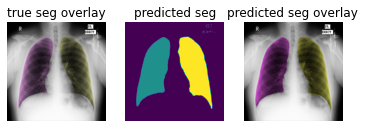

<Figure size 360x360 with 0 Axes>

Dice loss: 0.05070171877741814
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 41/100
	seg training loss: 0.16096656237329757
	seg validation loss: 0.10746543854475021


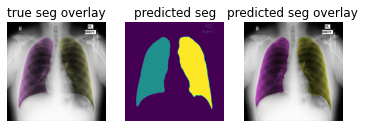

<Figure size 360x360 with 0 Axes>

Dice loss: 0.05073003098368645
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 42/100
	seg training loss: 0.1592929448400225
	seg validation loss: 0.10309964045882225


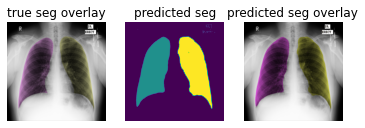

<Figure size 360x360 with 0 Axes>

Dice loss: 0.04944763705134392
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 43/100
	seg training loss: 0.1552657506295613
	seg validation loss: 0.10012605413794518


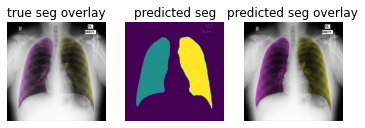

<Figure size 360x360 with 0 Axes>

Dice loss: 0.04876391217112541
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 44/100
	seg training loss: 0.15094017343861715
	seg validation loss: 0.09995420277118683


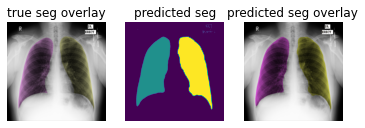

<Figure size 360x360 with 0 Axes>

Dice loss: 0.048186302185058594
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 45/100
	seg training loss: 0.14994233208043234
	seg validation loss: 0.09888662397861481


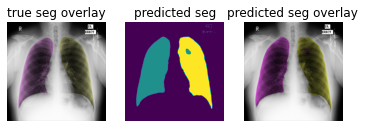

<Figure size 360x360 with 0 Axes>

Dice loss: 0.05230716988444328
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 46/100
	seg training loss: 0.1485207208565303
	seg validation loss: 0.09565330669283867


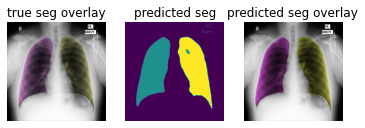

<Figure size 360x360 with 0 Axes>

Dice loss: 0.0501629114151001
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 47/100
	seg training loss: 0.14779110252857208
	seg validation loss: 0.09453687071800232


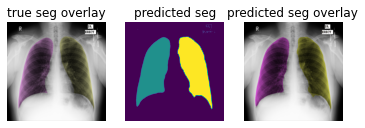

<Figure size 360x360 with 0 Axes>

Dice loss: 0.04713183641433716
	critic training loss: 0.0
	critic validation loss: 0.0
Epoch 48/100
	seg training loss: 0.14303627184459142
	seg validation loss: 0.09059004858136177


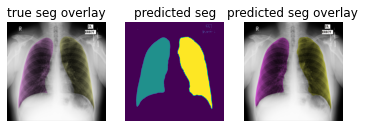

<Figure size 360x360 with 0 Axes>

Dice loss: 0.047381442040205
	critic training loss: 0.0
	critic validation loss: 0.0


In [ ]:
seg_net.to('cuda')
critic_net.to('cuda')

dataloader_train = monai.data.DataLoader(
    dataset_train,
    batch_size=16,
    num_workers=8,
    shuffle=True
)

dataloader_valid = monai.data.DataLoader(
    dataset_valid,
    batch_size=16,
    num_workers=8,
    shuffle=False
)

lambda0 = 0.000001 # How much weight to give to critic score when training seg_net

learning_rate_seg_net = 2e-4
optimizer_seg_net = torch.optim.Adam(seg_net.parameters(), learning_rate_seg_net)
training_losses_seg_net = [] 
validation_losses_seg_net = []

learning_rate_critic_net = 1e-3
optimizer_critic_net = torch.optim.Adam(critic_net.parameters(), learning_rate_critic_net)
training_losses_critic_net = [] 
validation_losses_critic_net = []



max_epochs = 100

for epoch_number in range(max_epochs):
    
    # --------------------------------
    #          seg train
    # --------------------------------
    
    swap_training(seg_net, critic_net)
    losses = []
    for batch in dataloader_train:
        imgs = batch['img'].to('cuda')
        true_segs = batch['seg'].to('cuda')

        optimizer_seg_net.zero_grad()
        predicted_segs = seg_net(imgs)
        critic_score = critic_net(predicted_segs)
        loss = dice_loss(predicted_segs, true_segs) +\
               lambda0 * bce_loss_logits(critic_score,torch.ones_like(critic_score))
        loss.backward()
        optimizer_seg_net.step()

        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    print(f"Epoch {epoch_number+1}/{max_epochs}\n\tseg training loss: {training_loss}")
    training_losses_seg_net.append([epoch_number, training_loss])
    
    # --------------------------------
    #          seg val
    # --------------------------------
    
    if (epoch_number%5 == 0)
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_valid:
                imgs = batch['img'].to('cuda')
                true_segs = batch['seg'].to('cuda')
                predicted_segs = seg_net(imgs)
                critic_score = critic_net(predicted_segs)
                loss = dice_loss(predicted_segs, true_segs) +\
                       lambda0 * bce_loss_logits(critic_score,torch.ones_like(critic_score))
                losses.append(loss.item())
            validation_loss = np.mean(losses)
        
        print(f"\tseg validation loss: {validation_loss}")
        validation_losses_seg_net.append([epoch_number, validation_loss])
    
    
    # --- Preview ---
    if (epoch_number%5 == 0)
        preview_seg_net(dataset_valid[12], figsize=(6,6), print_loss=False);
    
    
    
    # --------------------------------
    #         critic train
    # --------------------------------

    
    swap_training(critic_net, seg_net)
    losses = []
    for batch in dataloader_train:
        imgs = batch['img'].to('cuda')
        true_segs = batch['seg'].float().to('cuda')
        
        optimizer_critic_net.zero_grad()
        predicted_segs = seg_net(imgs)
        critic_generated_segs = critic_net(predicted_segs)
        critic_real_segs = critic_net(true_segs)
        loss = bce_loss_logits(critic_generated_segs, torch.zeros_like(critic_generated_segs)) +\
               bce_loss_logits(critic_real_segs, torch.ones_like(critic_real_segs))
        loss.backward()
        optimizer_critic_net.step()

        losses.append(loss.item())
    
    training_loss = np.mean(losses)
    print(f"\tcritic training loss: {training_loss}")
    training_losses_critic_net.append([epoch_number, training_loss])

    # --------------------------------
    #         critic val
    # --------------------------------
    
    if (epoch_number%5 == 0)
        critic_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_valid:
                imgs = batch['img'].to('cuda')
                true_segs = batch['seg'].float().to('cuda')
                predicted_segs = seg_net(imgs)
                critic_generated_segs = critic_net(predicted_segs)
                critic_real_segs = critic_net(true_segs)
                loss = bce_loss_logits(critic_generated_segs, torch.zeros_like(critic_generated_segs)) +\
                       bce_loss_logits(critic_real_segs, torch.ones_like(critic_real_segs))
                losses.append(loss.item())
            validation_loss = np.mean(losses)

        print(f"\tcritic validation loss: {validation_loss}")
        validation_losses_critic_net.append([epoch_number, validation_loss])
    
    

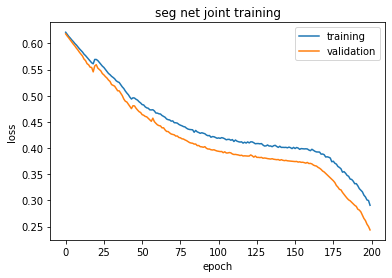

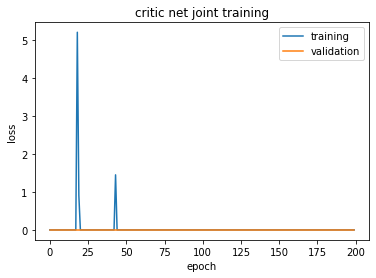

In [34]:
plt.plot(training_losses_seg_net, label="training")
plt.plot(validation_losses_seg_net, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('seg net joint training')
plt.savefig('seg_net_losses.png')
plt.show()

plt.plot(training_losses_critic_net, label="training")
plt.plot(validation_losses_critic_net, label="validation")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('critic net joint training')
plt.savefig('critic_net_losses.png')
plt.show()

In [33]:
# CHECKPOINT CELL; SAVE
# torch.save(seg_net.state_dict(),'seg_net4.pth')
# torch.save(critic_net.state_dict(),'critic_net4.pth')

In [32]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net4.pth'))
# critic_net.load_state_dict(torch.load('critic_net4.pth'))

<All keys matched successfully>

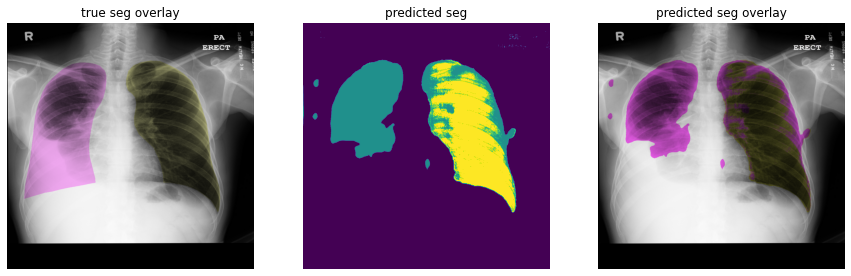

<Figure size 360x360 with 0 Axes>

Dice loss: 0.3114701807498932
Critic network confidence in the generated segmentation: 0.0
Associated BCE loss: 0.0
Critic network confidence in the ground truth segmentation: 1.0
Associated BCE loss: 0.0


In [32]:
#Try both networks on a random validation image
data_item  = random.choice(dataset_valid)
with torch.no_grad():
    preview_seg_net(data_item);
    preview_critic_net(data_item);

In [98]:
seg_net.load_state_dict(torch.load('seg_net3.pth'))

<All keys matched successfully>